In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

In [2]:
SEED = 1234

import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
data_dir = 'TestSet'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:1


In [5]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
    

In [6]:
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

# Test DataLoader

In [7]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))

test_loader = DataLoader( 
    dataset,
    num_workers=workers,
    batch_size=1,
)

# Model

In [8]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [9]:
resnet.load_state_dict(torch.load('GeorgiaTech-TestDataset_StateDict.pth'))

<All keys matched successfully>

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = { 
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

# Iterative Adversarial Attack

In [11]:
import cv2
import mediapipe as mp
import numpy as np
from math import hypot
from imutils import paths
import os


# Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh() 

In [12]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder(data_dir + '_cropped')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [13]:
def get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks):

 # Nose Co-ordinates
    if location == 'Nose':
        top = (facial_landmarks.landmark[8].x * frame_patch_width, facial_landmarks.landmark[8].y * frame_patch_height)
        center = (facial_landmarks.landmark[195].x * frame_patch_width, facial_landmarks.landmark[195].y * frame_patch_height)

        left_point = (facial_landmarks.landmark[190].x * frame_patch_width, facial_landmarks.landmark[190].y * frame_patch_height)
        right_point = (facial_landmarks.landmark[413].x * frame_patch_width, facial_landmarks.landmark[413].y * frame_patch_height)

        # patch_width = int(hypot(left_point[0] - right_point[0],
        #                     left_point[1] - right_point[1]))

        patch_width = global_patch_width
        patch_height = int(patch_width)                      

        top_left = (int(center[0] - patch_width / 2),
                        int(center[1] - patch_height /2))

        bottom_right = (int(center[0] + patch_width / 2),
                            int(center[1] + patch_height / 2))

    # EyeBrow Coordinates
    if location == 'Eyebrow':
        #top = (facial_landmarks.landmark[71].x * patch_width, facial_landmarks.landmark[71].y * patch_height)
        center = (facial_landmarks.landmark[69].x * frame_patch_width, facial_landmarks.landmark[69].y * frame_patch_height)

        left_point = (facial_landmarks.landmark[71].x * frame_patch_width, facial_landmarks.landmark[71].y * frame_patch_height)
        right_point = (facial_landmarks.landmark[108].x * frame_patch_width, facial_landmarks.landmark[108].y * frame_patch_height)

        #patch_width = int(hypot(left_point[0] - right_point[0],
        #                     left_point[1] - right_point[1]))

        patch_width = global_patch_width
        patch_height = int(patch_width)                      

        top_left = (int(center[0] - patch_width / 2),
                        int(center[1] - patch_height /2))

        bottom_right = (int(center[0] + patch_width / 2),
                            int(center[1] + patch_height / 2))


    # Chin Coordinates
    if location == 'Chin':
        center = (facial_landmarks.landmark[199].x * frame_patch_width, facial_landmarks.landmark[199].y * frame_patch_height)

        left_point = (facial_landmarks.landmark[140].x * frame_patch_width, facial_landmarks.landmark[140].y * frame_patch_height)
        right_point = (facial_landmarks.landmark[428].x * frame_patch_width, facial_landmarks.landmark[428].y * frame_patch_height)

        # patch_width = int(hypot(left_point[0] - right_point[0],
        #                     left_point[1] - right_point[1]))

        patch_width = global_patch_width
        patch_height = int(patch_width)                      

        top_left = (int(center[0] - patch_width / 2),
                        int(center[1] - patch_height /2))

        bottom_right = (int(center[0] + patch_width / 2),
                            int(center[1] + patch_height / 2))

    # Cheek Coordinates
    if location == 'Cheek':
        center = (facial_landmarks.landmark[205].x * frame_patch_width, facial_landmarks.landmark[205].y * frame_patch_height)

        # patch_width = int(hypot(left_point[0] - right_point[0],
        #                     left_point[1] - right_point[1]))

        patch_width = global_patch_width
        patch_height = int(patch_width)                      

        top_left = (int(center[0] - patch_width / 2),
                        int(center[1] - patch_height /2))
        
    # Cheek Coordinates
    if location == 'Lips':
        center = (facial_landmarks.landmark[15].x * frame_patch_width, facial_landmarks.landmark[15].y * frame_patch_height)

        # patch_width = int(hypot(left_point[0] - right_point[0],
        #                     left_point[1] - right_point[1]))

        patch_width = global_patch_width
        patch_height = int(patch_width)                      

        top_left = (int(center[0] - patch_width / 2),
                        int(center[1] - patch_height /2))
        
     # Cheek Coordinates
    if location == 'Forehead':
        center = (facial_landmarks.landmark[10].x * frame_patch_width, facial_landmarks.landmark[10].y * frame_patch_height)

        # patch_width = int(hypot(left_point[0] - right_point[0],
        #                     left_point[1] - right_point[1]))

        patch_width = global_patch_width
        patch_height = int(patch_width)                      

        top_left = (int(center[0] - patch_width / 2),
                        int(center[1] - patch_height /2))


            
    return patch_width, patch_height, top_left

In [14]:
def get_multi_landmarks(location, frame_width, frame_height, target_patch_size_w, target_patch_size_h, facial_landmarks):

    if location == 'N-C-C':  # NOSE-CHEEK-CHIN
        ## NOSE

        nose_center = (facial_landmarks.landmark[195].x * frame_width, facial_landmarks.landmark[195].y * frame_height)

        nose_patch_width = target_patch_size_w
        nose_patch_height = target_patch_size_h                      

        nose_top_left = (int(nose_center[0] - nose_patch_width / 2),
                        int(nose_center[1] - nose_patch_height /2))            

        ## CHEEK 
        cheek_center = (facial_landmarks.landmark[50].x * frame_width, facial_landmarks.landmark[50].y * frame_height)

        cheek_patch_width = target_patch_size_w
        cheek_patch_height = target_patch_size_h                      

        cheek_top_left = (int(cheek_center[0] - cheek_patch_width / 2),
                        int(cheek_center[1] - cheek_patch_height /2))

        ## CHIN
        chin_center = (facial_landmarks.landmark[18].x * frame_width, facial_landmarks.landmark[18].y * frame_height)

        chin_patch_width = target_patch_size_w
        chin_patch_height = target_patch_size_h                      

        chin_top_left = (int(chin_center[0] - chin_patch_width / 2),
                        int(chin_center[1] - chin_patch_height /2))

    return nose_patch_width, nose_patch_height, nose_top_left, cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width, chin_patch_height, chin_top_left

In [16]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    
    noise_matrix = epsilon*sign_data_grad
    #torch.save(noise_matrix, "NoiseMatrix_{0}.pth".format(eps_value))
    return perturbed_image, noise_matrix


In [31]:
def create_frame_for_single_landmarks(frame, noise_matrix, patch_width, patch_height, top_left, bd_image, patch=True):
    
    np_img = noise_matrix[0].detach().cpu().numpy()
    np_img = np.transpose(np_img, (1,2,0))

    reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width]

    if patch:

        if reqd_matrix.shape[1] == 0:
            #print("No landmark found for Image - ", i_batch)
            #print(reqd_matrix.shape) 
            #continue
            
            print("Issue in required matrix")
            #break

        bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))


        noisy_patch = bd_image + bd_image * reqd_matrix
        noisy_patch = noisy_patch.clip(0, 255)

         # Adding the Band Aid Image
        bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
        bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

        location_area = frame[top_left[1]: top_left[1] + patch_height,
                    top_left[0]: top_left[0] + patch_width]

        if mask.shape != location_area.shape:
            mask = cv2.resize(mask, (location_area.shape[1], location_area.shape[0]))

        mask = mask.astype(np.uint8)
        bd_pic = bd_pic.astype(np.uint8)

        #try:
        location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)
#                     except:
#                         print("Mask Shape - ", mask.shape, "Location shape - ", location_area.shape)

        if bd_pic.shape!= location_area_no_loc.shape:
            bd_pic = cv2.resize(bd_pic, (location_area_no_loc.shape[1], location_area_no_loc.shape[0]))

        #try:
        final_nose = cv2.add(location_area_no_loc, bd_pic)
#                     except:
#                         print("Location Shape - ", location_area_no_loc.shape, "BD-", bd_pic.shape)

        frame[top_left[1]: top_left[1] + patch_height,
            top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
            top_left[0]: top_left[0] + patch_width] + final_nose

    else:
        frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] + reqd_matrix
        
        
    return frame


In [32]:
def create_frame_for_multi_landmark(frame, noise_matrix, nose_patch_width, nose_patch_height, nose_top_left, 
                                    cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width, chin_patch_height, chin_top_left, bd_image, patch=True):
    
    np_img = noise_matrix[0].detach().cpu().numpy() # SIZE of our IMAGE
    np_img = np.transpose(np_img, (1,2,0))


    ###################### Processing for NOSE ########################


    nose_area = np_img[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                nose_top_left[0]: nose_top_left[0] + nose_patch_width]

    if patch:

        bd_image_nose = cv2.resize(bd_image, (nose_area.shape[1], nose_area.shape[0]))

        noisy_patch_nose = bd_image_nose + bd_image_nose * nose_area
        noisy_patch_nose = noisy_patch_nose.clip(0, 255)

         # Adding the Band Aid Image
        bd_pic_nose = cv2.resize(noisy_patch_nose, (nose_patch_width, nose_patch_height))
        bd_pic_nose_gray = cv2.cvtColor(bd_pic_nose, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(bd_pic_nose_gray, 25, 255, cv2.THRESH_BINARY_INV)

        mask = mask.astype(np.uint8)
        bd_pic_nose = bd_pic_nose.astype(np.uint8)

        #print("NOSE - ", nose_area.shape, mask.shape)

        nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=mask)

        #print(nose_area_no_nose.shape, bd_pic_nose.shape)

        nose_area_no_nose = nose_area_no_nose.astype(np.uint8)

        nose_final_loc = cv2.add(nose_area_no_nose, bd_pic_nose)
        nose_final_loc = cv2.cvtColor(nose_final_loc, cv2.COLOR_BGR2RGB)

        frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                    nose_top_left[0]: nose_top_left[0] + nose_patch_width] = frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                    nose_top_left[0]: nose_top_left[0] + nose_patch_width] + nose_final_loc


    else:
        frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                    nose_top_left[0]: nose_top_left[0] + nose_patch_width] = frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                    nose_top_left[0]: nose_top_left[0] + nose_patch_width] + nose_area

    ##################### Processing for CHEEK ########################


    cheek_area = np_img[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width]

    if patch:
        #try:

        if cheek_area.shape[1] or cheek_area.shape[0] == 0:
            print("Cheek Area Shape Issue")
            #break

        bd_image_cheek = cv2.resize(bd_image, (cheek_area.shape[1], cheek_area.shape[0]))
    #                     except:
    #                         print("Maybe Cheek Area issue- ", cheek_area.shape)

        noisy_patch_cheek = bd_image_cheek + bd_image_cheek * cheek_area
        noisy_patch_cheek = noisy_patch_cheek.clip(0, 255)

         # Adding the Band Aid Image
        bd_pic_cheek = cv2.resize(noisy_patch_cheek, (cheek_patch_width, cheek_patch_height))
        bd_pic_cheek_gray = cv2.cvtColor(bd_pic_cheek, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(bd_pic_cheek_gray, 25, 255, cv2.THRESH_BINARY_INV)

        mask = mask.astype(np.uint8)
        bd_pic_cheek = bd_pic_cheek.astype(np.uint8)

        #print("CHEEK - ", cheek_area.shape, mask.shape)

        cheek_area_no_cheek = cv2.bitwise_and(cheek_area, cheek_area, mask=mask)

        cheek_area_no_cheek = cheek_area_no_cheek.astype(np.uint8)

        cheek_final_loc = cv2.add(cheek_area_no_cheek, bd_pic_cheek)
        cheek_final_loc = cv2.cvtColor(cheek_final_loc, cv2.COLOR_BGR2RGB)

        frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                    cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] = frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                    cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] + cheek_final_loc

    else:
        frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                    cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] = frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                    cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] + cheek_area


    ###################### Processing for CHIN ##############################
    chin_area = np_img[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                    chin_top_left[0]: chin_top_left[0] + chin_patch_width]

    chin_area = cv2.resize(chin_area, (mask.shape[1], mask.shape[0]))

    if patch:
        bd_image_chin = cv2.resize(bd_image, (nose_area.shape[1], nose_area.shape[0]))

        noisy_patch_chin = bd_image_chin + bd_image_chin * chin_area
        noisy_patch_chin = noisy_patch_cheek.clip(0, 255)

         # Adding the Band Aid Image
        bd_pic_chin = cv2.resize(noisy_patch_chin, (chin_patch_width, chin_patch_height))
        bd_pic_chin_gray = cv2.cvtColor(bd_pic_chin, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(bd_pic_chin_gray, 25, 255, cv2.THRESH_BINARY_INV)

        mask = mask.astype(np.uint8)
        bd_pic_chin = bd_pic_chin.astype(np.uint8)


        #print("CHIN - ", chin_area.shape, mask.shape)

        chin_area_no_chin = cv2.bitwise_and(chin_area, chin_area, mask=mask)

        chin_area_no_chin = chin_area_no_chin.astype(np.uint8)

        chin_final_loc = cv2.add(chin_area_no_chin, bd_pic_chin)
        x, yy = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                    chin_top_left[0]: chin_top_left[0] + chin_patch_width].shape[1], frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                    chin_top_left[0]: chin_top_left[0] + chin_patch_width].shape[0]

        chin_final_loc = cv2.resize(chin_final_loc, (x, yy))
        chin_final_loc = cv2.cvtColor(chin_final_loc, cv2.COLOR_BGR2RGB)

        frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                    chin_top_left[0]: chin_top_left[0] + chin_patch_width] = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                    chin_top_left[0]: chin_top_left[0] + chin_patch_width] + chin_final_loc

        #plt.imshow(frame)
    else:
        frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                    chin_top_left[0]: chin_top_left[0] + chin_patch_width] = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                    chin_top_left[0]: chin_top_left[0] + chin_patch_width] + chin_final_loc
        
        
    return frame


In [33]:
# PGD Attack
# PROJECTED GRADIENT DESCENT
import torch
import torch.nn as nn

def pgd_attack(model, image, label, eps=1, alpha=255/255, iters=40) :
    image = image.to(device)
    label = label.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_image = image.data
        
    for i in range(iters) :    
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()

        perturbed_image = image + alpha*image.grad.sign()
        eta = torch.clamp(perturbed_image - ori_image, min=-eps, max=eps)
                
        image = torch.clamp(perturbed_image + eta, min=0, max=1).detach_()
            
    return image, eta



In [40]:
loop_005 = []
loop_01 = []
loop_02 = []
loop_04 = []
loop_1 = []
loop_3 = []
loop_5 = []

def pass_epoch(
    model, eps, patch, LOCATION, SIZE, loss_fn, loader,
    device='cuda'
):
    
    mode = 'Train' if model.training else 'Valid'
    loss = 0
    metrics = {}
    
    epsilon_value = eps
    location = LOCATION
    global_patch_width = SIZE
    target_patch_size_w, target_patch_size_h = SIZE, SIZE

    correct = 0
    num_fooled = 0
    
    adv_examples = []
    
    bd_image = cv2.imread("BD.jpeg")
    bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)

    from torchvision import transforms
    trans = transforms.Compose([transforms.ToTensor()])
    
    for i_batch, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        
        loop_count = 0
        
        X.requires_grad = True
        
        y_pred = model(X)
        loss_batch = loss_fn(y_pred, y)

        init_pred = y_pred.max(1, keepdim=True)[1] # get the index of the max log-probability
        

        #If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != y.item():
            print("INSIDE")
            print(init_pred, y)
            continue
            
        image, noise_matrix_orig = pgd_attack(resnet, X, y, eps=epsilon_value, iters=1)
         
        
        ####### FRAME OPERATIONS NOW ###########
        
        frame = X[0].detach().cpu().numpy()
        frame = np.transpose(frame, (1,2,0))
        frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!

        frame_height, frame_width, _ = frame.shape

        result = face_mesh.process(frame)
        
        for facial_landmarks in result.multi_face_landmarks:
            
            if location == 'N-C-C':
        
                nose_patch_width, nose_patch_height, nose_top_left, cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width, chin_patch_height, chin_top_left = get_multi_landmarks(location, frame_width, frame_height, 
                                                                                    target_patch_size_w, target_patch_size_h, facial_landmarks)

                frame = create_frame_for_multi_landmark(frame, noise_matrix_orig, nose_patch_width, nose_patch_height, nose_top_left, 
                                    cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width,
                                                        chin_patch_height, chin_top_left, bd_image, patch=True)

            
            else:
    
                patch_width, patch_height, top_left = get_landmarks(location, frame_width, 
                                                                    frame_height, global_patch_width, facial_landmarks)


                frame = create_frame_for_single_landmarks(frame, noise_matrix_orig, patch_width, patch_height, top_left, bd_image, patch=True)
                
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        aligned = []
        x_aligned, prob = mtcnn(frame, return_prob=True)
        aligned.append(x_aligned)
        
        try:
            faces = torch.stack(aligned).to(device)
        except:
            print("Issue in tensor - ", faces.shape)
    
                        
        output = model(faces)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        if final_pred.item() != y.item():
            print("Fooled in the first iteration itself, IMAGE - ", i_batch)
            
            if epsilon_value == 0.05:
                loop_005.append(1)

            if epsilon_value == 0.1:
                loop_01.append(1)

            if epsilon_value == 0.2:
                loop_02.append(1)

            if epsilon_value == 0.4:
                loop_04.append(1)

            if epsilon_value == 1:
                loop_1.append(1)
                
            if epsilon_value == 3:
                loop_3.append(1)
                
            if epsilon_value == 5:
                loop_5.append(1)
            
            
        if final_pred.item() == y.item():
            print("Image No - ", i_batch)
            
            for i in range(200):
                 #print("Loop Count - {0} for Image - {1} ".format(i, i_batch))
                                
                #perturbed_data, noise_matrix = fgsm_attack(faces, epsilon_value, data_grad)
                
                perturbed_data, noise_matrix = pgd_attack(resnet, faces, y, eps=epsilon_value, iters=1)

                added_noise_matrix = noise_matrix + noise_matrix_orig
                
                noise_matrix_orig = added_noise_matrix
                
                for facial_landmarks in result.multi_face_landmarks:
                    
                    if location == 'N-C-C':
        
                        nose_patch_width, nose_patch_height, nose_top_left, cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width, chin_patch_height, chin_top_left = get_multi_landmarks(location, frame_width, frame_height, 
                                                                                    target_patch_size_w, target_patch_size_h, facial_landmarks)

                        frame = create_frame_for_multi_landmark(frame, noise_matrix_orig, nose_patch_width, nose_patch_height, nose_top_left, 
                                                cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width,
                                                        chin_patch_height, chin_top_left, bd_image, patch=True)

            
                    else:

                        patch_width, patch_height, top_left = get_landmarks(location, frame_width, frame_height, global_patch_width, facial_landmarks)

                        frame = create_frame_for_single_landmarks(frame, noise_matrix_orig, patch_width, patch_height, top_left, bd_image, patch=True)
                
                                         
                aligned = []
                x_aligned, prob = mtcnn(frame, return_prob=True)
                aligned.append(x_aligned)
                
                try:
                    faces = torch.stack(aligned).to(device)
                except:
                    print("Issue in tensor - ", faces.shape)

                output = model(faces)

                 # Check for success
                final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                
                if i > 198:
                    print("Breaking out of loop for Image - {0} didn't fool".format(i_batch))
                    break
                
                if final_pred.item() != y.item():
                    print("For epsilon - {0} and Image - {1} it took {2} loops".format(epsilon_value, i_batch, i+2))
                    
                    if epsilon_value == 0.05:
                        loop_005.append(i+2)

                    if epsilon_value == 0.1:
                        loop_01.append(i+2)

                    if epsilon_value == 0.2:
                        loop_02.append(i+2)

                    if epsilon_value == 0.4:
                        loop_04.append(i+2)

                    if epsilon_value == 1:
                        loop_1.append(i+2)
                        
                    if epsilon_value == 3:
                        loop_3.append(1)
                
                    if epsilon_value == 5:
                        loop_5.append(1)
                    
                    break
                    
            #final_matrix = final_matrix + noise_matrix
            print(epsilon_value, final_pred.item(), y.item())
             
            
        else:
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon_value == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() != y.item():
            #print("FOOLED !!! ", final_pred.item(), y.item())
            num_fooled += 1
            
    
                        
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
                #epsilons.append(epsilon_value)
                
                
    fool_rate = num_fooled/float(len(loader))
    print("Epsilon: {}\tFool Rate = {} / {} = {}".format(epsilon_value, num_fooled, len(loader), fool_rate))
    
    #torch.save(final_matrix, "NoiseMatrix_{0}.pth".format(epsilon_value))
    return fool_rate, adv_examples, epsilon_value, loop_005, loop_01, loop_02, loop_04, loop_1, loop_3, loop_5

In [41]:
%%time
import time

fool_rates = []
examples = []

#epsilons = [0.05, 0.1, 0.2, 0.4, 1, 3, 5]
epsilons = [1]

resnet.eval()

LOCATION = 'Nose'
TARGET_PATCH_SIZE = 32

patch = True

start = time.time()

for eps in epsilons:
    fool_rate, ex, eps_value, loop_005, loop_01, loop_02, loop_04, loop_1, loop_3, loop_5= pass_epoch(
        resnet, eps, patch, LOCATION, TARGET_PATCH_SIZE, loss_fn, test_loader, device=device
    )

    fool_rates.append(fool_rate)
    examples.append(ex)
    

end = time.time() - start

print("Time taken for this run - ", end)

Image No -  0
Breaking out of loop for Image - 0 didn't fool
1 0 0
Image No -  1
Breaking out of loop for Image - 1 didn't fool
1 0 0
Image No -  2
Breaking out of loop for Image - 2 didn't fool
1 0 0
Image No -  3
Breaking out of loop for Image - 3 didn't fool
1 0 0
Image No -  4
Breaking out of loop for Image - 4 didn't fool
1 0 0
Image No -  5
For epsilon - 1 and Image - 5 it took 49 loops
1 31 1
Image No -  6
Breaking out of loop for Image - 6 didn't fool
1 1 1
Fooled in the first iteration itself, IMAGE -  7
Image No -  8
Breaking out of loop for Image - 8 didn't fool
1 1 1
Image No -  9
Breaking out of loop for Image - 9 didn't fool
1 1 1
Image No -  10
For epsilon - 1 and Image - 10 it took 81 loops
1 31 1
Image No -  11
Breaking out of loop for Image - 11 didn't fool
1 2 2
Image No -  12
Breaking out of loop for Image - 12 didn't fool
1 2 2
Image No -  13
Breaking out of loop for Image - 13 didn't fool
1 2 2
Image No -  14
Breaking out of loop for Image - 14 didn't fool
1 2 2
I

In [42]:
fool_rates

######## PATCH SIZE - 30 #########

# 20% on BD Epsilon - 5 - 300 loops
# 19.2% on Epsilon - 10

# 19.2% on Epsilon - 20
# 23.2% on Epsilon - 0.1 !


######## PATCH SIZE - 60 #########

# 77.6% on BD Epsilon - 0.05 - 200 loops - avg iterations - 26
# 78.8% on BD Epsilon - 1 - 200 loops - avg iterations - 48
# 80.4% on BD Epsilon - 3 - 200 loops - avg iterations - 56
# 80% on BD Epsilon - 5 - 200 loops - avg iterations - 56


############ N-C-C - 20 ############

# 5.6% on Epsilon 1
# 15.2% on Size 30


#############  NOSE - 32  #############

# 21.6% on Epsilon 0.05 - Avg Iterations - 49.46
# 24% on Epsilon 0.1 - Avg Iterations - 51.5
# 24% on Epsilon 0.2 - Avg Iterations - 80.9
# 24% on Epsilon 0.4 - Avg Iterations - 68.16
# 22.8% on Epsilon 1 -Avg Iteration - 96.8



#############  NOSE - 45  #############

# 40.5% on Epsilon 0.05 - Avg Iterations - 35.27
# 43.8% on Epsilon 0.1 - Avg Iterations - 43.24
# 43% on Epsilon 0.2 - Avg Iterations - 48.3
# 41% on Epsilon 0.4 - Avg Iterations - 41.6
# 46.21% on Epsilon 1 -Avg Iteration - 63.52
# 44.6% on Epsilon 3 -Avg Iteration - 62.68
# 44.6% on Epsilon 5 -Avg Iteration - 62.68

[0.22310756972111553]

In [20]:
print(len(loop_005)) 
print(len(loop_01))
print(len(loop_02))
print(len(loop_04))
print(len(loop_1))

101
109
108
102
116


In [22]:
np.save('LoopsArray/New-3-8-21/45x45/Nose/loop_0.05-45x45-40.5%.npy', loop_005)
np.save('LoopsArray/New-3-8-21/45x45/Nose/loop_0.1-45x45-43.8%.npy', loop_01)
np.save('LoopsArray/New-3-8-21/45x45/Nose/loop_0.2-45x45-43%.npy', loop_02)
np.save('LoopsArray/New-3-8-21/45x45/Nose/loop_0.4-45x45-41%.npy', loop_04)
np.save('LoopsArray/New-3-8-21/45x45/Nose/loop_1-45x45-46.21%.npy', loop_1)


#loop_005

In [48]:
len(loop_005)

53

In [33]:
x = 0

array = loop_5

length = len(array)

for i in array:
    x = x + i
    
print("Avg iterations - ", x/length)

Avg iterations -  62.6875


In [21]:
fool_rates_45 = [element * 100 for element in fool_rates]  
fool_rates_45

[40.23904382470119,
 43.82470119521912,
 43.02788844621514,
 41.03585657370518,
 46.21513944223107]

In [ ]:
np.save('LoopsArray/New-3-8-21/32x32/Nose/fool_rates_32.npy', fool_rates_32)

In [47]:
import pandas as pd

# creating the DataFrame
final_rates = pd.DataFrame(list(zip(fool_rates_30, fool_rates_20, fool_rates_15, fool_rates_10, fool_rates_5, fool_rates_1))) 
  
print(final_rates)

      0     1     2     3     4     5
0  94.4  94.4  94.4  94.4  94.4  94.4
1  94.8  94.4  94.4  94.4  94.4  94.4
2  94.8  94.4  94.4  94.4  94.4  94.4
3  94.8  94.4  94.4  94.4  94.4  94.4
4  94.8  94.4  94.4  94.4  94.4  94.4
5  94.8  94.4  94.4  94.4  94.4  94.4
6  94.8  94.4  94.4  94.4  94.4  94.4
7  94.8  94.4  94.4  94.4  94.4  94.4
8  94.8  94.4  94.4  94.4  94.4  94.4


In [48]:
final_rates.columns =['32x32', '16x16', '8x8']

In [49]:
final_rates.to_csv('New-FoolRates.csv', index=epsilons)

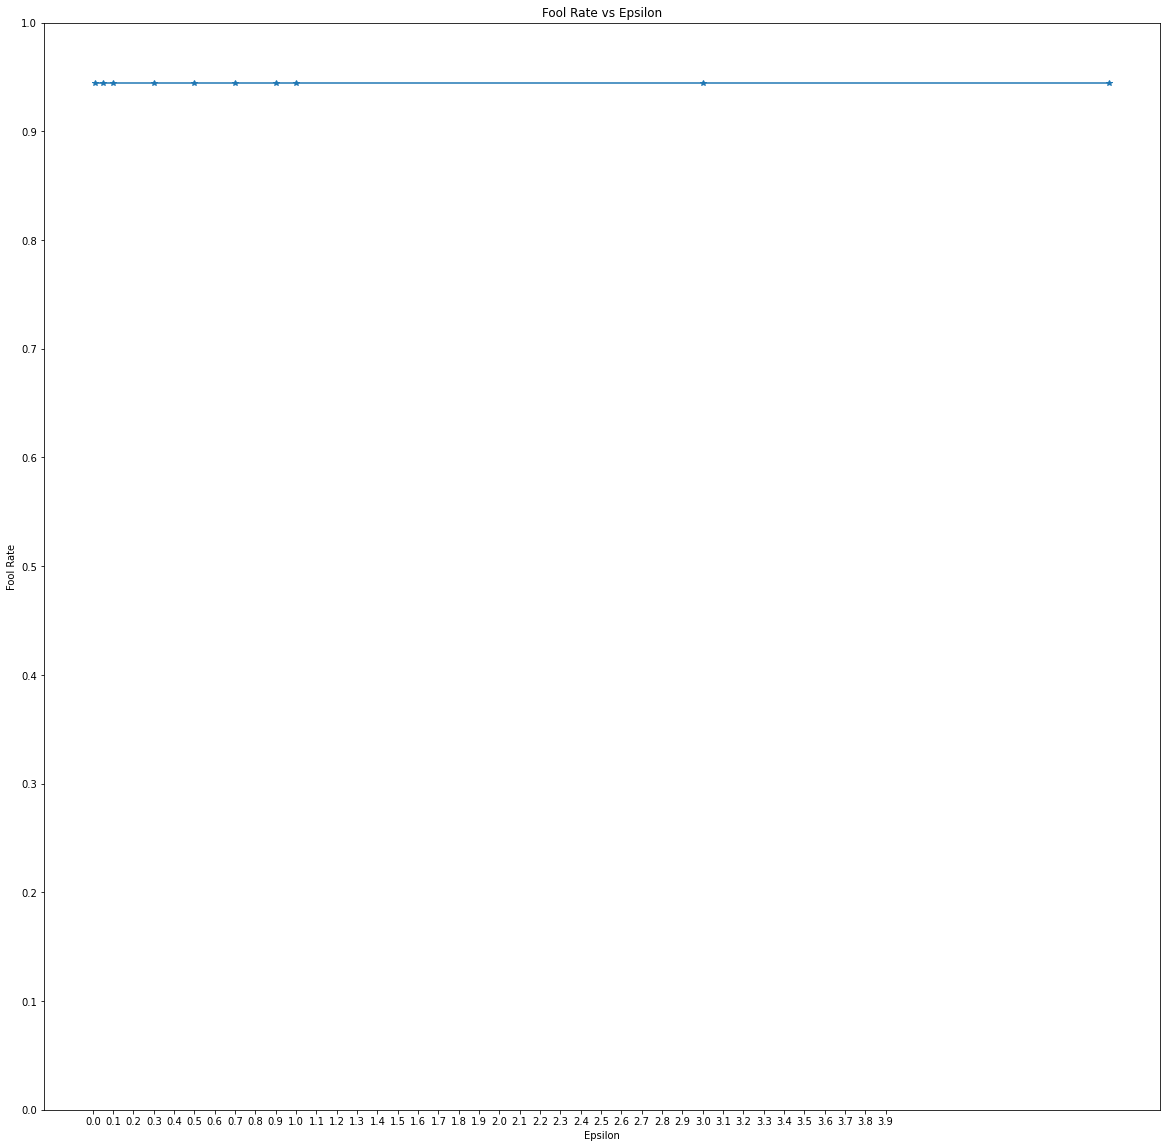

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.plot(epsilons, fool_rates, "*-")

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 4, step=0.1))
plt.title("Fool Rate vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Fool Rate")
#plt.savefig("MediaPipe-30x30.png", dpi = 100, facecolor = 'white')
plt.show()

In [27]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


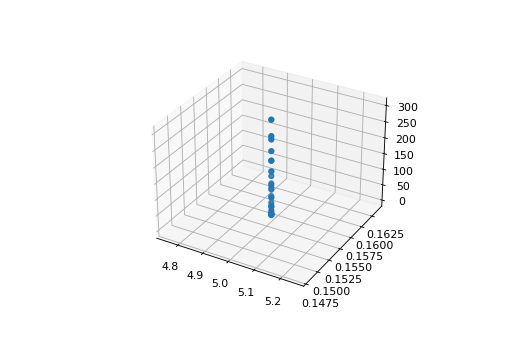

In [62]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

In [58]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line

ax.plot3D(epsilons, fool_rates, loop_5, 'red')

# # Data for three-dimensional scattered points
# zdata = 15 * np.random.random(100)
# xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
# ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
# ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

In [63]:
#ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
ax.scatter3D(epsilons, fool_rates, loop_5, 'Pink')

In [51]:
fool_rates = []
for i in range(75):
    fool_rates.append(0.156)

In [52]:
len(fool_rates)

75

In [53]:
for i in range(74):
    epsilons.append(5)

In [54]:
len(epsilons)

75

In [44]:
resnet.eval()
model = resnet

mode = 'Train' if model.training else 'Valid'
loss = 0
metrics = {}


epsilon_value = 0.05
location = 'N-C-C'
SIZE = 20
global_patch_width = SIZE
target_patch_size_w, target_patch_size_h = SIZE, SIZE

correct = 0
num_fooled = 0

adv_examples = []
loop_005 = []
loop_1 = []
loop_3 = []
loop_5 = []
loop_10 = []


bd_image = cv2.imread("BD.jpeg")
bd_image = cv2.cvtColor(bd_image, cv2.COLOR_BGR2RGB)

from torchvision import transforms
trans = transforms.Compose([transforms.ToTensor()])

X, Y = next(iter(test_loader))

#Y = torch.tensor([0])

X = X.to(device)
Y = Y.to(device)

loop_count = 0

X.requires_grad = True

y_pred = model(X)
loss_batch = loss_fn(y_pred, Y)

init_pred = y_pred.max(1, keepdim=True)[1] # get the index of the max log-probability

i_batch = 1
#If the initial prediction is wrong, dont bother attacking, just move on
if init_pred.item() != Y.item():
    print("INSIDE")
    print(init_pred, Y)
    #continue

model.zero_grad()
loss_batch.backward()

data_grad = X.grad.data 

perturbed_data, noise_matrix_orig = fgsm_attack(X, epsilon_value, data_grad)

####### FRAME OPERATIONS NOW ###########

frame = X[0].detach().cpu().numpy()
frame = np.transpose(frame, (1,2,0))
frame = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) ## V.V.IMP!!

frame_height, frame_width, _ = frame.shape

result = face_mesh.process(frame)

for facial_landmarks in result.multi_face_landmarks:

    if location == 'N-C-C':

        nose_patch_width, nose_patch_height, nose_top_left, cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width, chin_patch_height, chin_top_left = get_multi_landmarks(location, frame_width, frame_height, 
                                                                            target_patch_size_w, target_patch_size_h, facial_landmarks)

        np_img = noise_matrix_orig[0].detach().cpu().numpy() # SIZE of our IMAGE
        np_img = np.transpose(np_img, (1,2,0))



        ###################### Processing for NOSE ########################



        nose_area = np_img[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                    nose_top_left[0]: nose_top_left[0] + nose_patch_width]

        if patch:

            bd_image_nose = cv2.resize(bd_image, (nose_area.shape[1], nose_area.shape[0]))

            noisy_patch_nose = bd_image_nose + bd_image_nose * nose_area
            noisy_patch_nose = noisy_patch_nose.clip(0, 255)

             # Adding the Band Aid Image
            bd_pic_nose = cv2.resize(noisy_patch_nose, (nose_patch_width, nose_patch_height))
            bd_pic_nose_gray = cv2.cvtColor(bd_pic_nose, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(bd_pic_nose_gray, 25, 255, cv2.THRESH_BINARY_INV)

            mask = mask.astype(np.uint8)
            bd_pic_nose = bd_pic_nose.astype(np.uint8)

            print("NOSE - ", nose_area.shape, mask.shape)

            nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=mask)

            #print(nose_area_no_nose.shape, bd_pic_nose.shape)

            nose_area_no_nose = nose_area_no_nose.astype(np.uint8)

            nose_final_loc = cv2.add(nose_area_no_nose, bd_pic_nose)
            nose_final_loc = cv2.cvtColor(nose_final_loc, cv2.COLOR_BGR2RGB)

            frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                        nose_top_left[0]: nose_top_left[0] + nose_patch_width] = frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                        nose_top_left[0]: nose_top_left[0] + nose_patch_width] + nose_final_loc


        else:
            frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                        nose_top_left[0]: nose_top_left[0] + nose_patch_width] = frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                        nose_top_left[0]: nose_top_left[0] + nose_patch_width] + nose_area

        ##################### Processing for CHEEK ########################


        cheek_area = np_img[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                    cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width]

        if patch:
            bd_image_cheek = cv2.resize(bd_image, (cheek_area.shape[1], cheek_area.shape[0]))

            noisy_patch_cheek = bd_image_cheek + bd_image_cheek * cheek_area
            noisy_patch_cheek = noisy_patch_cheek.clip(0, 255)

             # Adding the Band Aid Image
            bd_pic_cheek = cv2.resize(noisy_patch_cheek, (cheek_patch_width, cheek_patch_height))
            bd_pic_cheek_gray = cv2.cvtColor(bd_pic_cheek, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(bd_pic_cheek_gray, 25, 255, cv2.THRESH_BINARY_INV)

            mask = mask.astype(np.uint8)
            bd_pic_cheek = bd_pic_cheek.astype(np.uint8)

            print("CHEEK - ", cheek_area.shape, mask.shape)

            cheek_area_no_cheek = cv2.bitwise_and(cheek_area, cheek_area, mask=mask)

            cheek_area_no_cheek = cheek_area_no_cheek.astype(np.uint8)

            cheek_final_loc = cv2.add(cheek_area_no_cheek, bd_pic_cheek)
            cheek_final_loc = cv2.cvtColor(cheek_final_loc, cv2.COLOR_BGR2RGB)

            frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                        cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] = frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                        cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] + cheek_final_loc

        else:
            frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                        cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] = frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                        cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] + cheek_area


        ###################### Processing for CHIN ##############################
        chin_area = np_img[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width]

        chin_area = cv2.resize(chin_area, (mask.shape[1], mask.shape[0]))

        if patch:
            bd_image_chin = cv2.resize(bd_image, (nose_area.shape[1], nose_area.shape[0]))

            noisy_patch_chin = bd_image_chin + bd_image_chin * chin_area
            noisy_patch_chin = noisy_patch_cheek.clip(0, 255)

             # Adding the Band Aid Image
            bd_pic_chin = cv2.resize(noisy_patch_chin, (chin_patch_width, chin_patch_height))
            bd_pic_chin_gray = cv2.cvtColor(bd_pic_chin, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(bd_pic_chin_gray, 25, 255, cv2.THRESH_BINARY_INV)

            mask = mask.astype(np.uint8)
            bd_pic_chin = bd_pic_chin.astype(np.uint8)


            print("CHIN - ", chin_area.shape, mask.shape)

            chin_area_no_chin = cv2.bitwise_and(chin_area, chin_area, mask=mask)

            chin_area_no_chin = chin_area_no_chin.astype(np.uint8)

            chin_final_loc = cv2.add(chin_area_no_chin, bd_pic_chin)
            x, y = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width].shape[1], frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width].shape[0]

            chin_final_loc = cv2.resize(chin_final_loc, (x, y))
            chin_final_loc = cv2.cvtColor(chin_final_loc, cv2.COLOR_BGR2RGB)

            frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width] = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width] + chin_final_loc

            #plt.imshow(frame)
        else:
            frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width] = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                        chin_top_left[0]: chin_top_left[0] + chin_patch_width] + chin_final_loc


    else:
        global_patch_width = 60
        patch_width, patch_height, top_left = get_landmarks(location, frame_width, frame_height, global_patch_width, facial_landmarks)

        np_img = noise_matrix_orig[0].detach().cpu().numpy()
        np_img = np.transpose(np_img, (1,2,0))

        reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                    top_left[0]: top_left[0] + patch_width]

        if patch:

            bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))

            noisy_patch = bd_image + bd_image * reqd_matrix
            noisy_patch = noisy_patch.clip(0, 255)

             # Adding the Band Aid Image
            bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
            bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
            _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

            location_area = frame[top_left[1]: top_left[1] + patch_height,
                        top_left[0]: top_left[0] + patch_width]

            if mask.shape != location_area.shape:
                mask = cv2.resize(mask, (location_area.shape[1], location_area.shape[0]))

            mask = mask.astype(np.uint8)
            bd_pic = bd_pic.astype(np.uint8)

            try:
                location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)
            except:
                print("Mask Shape - ", mask.shape, "Location shape - ", location_area.shape)

            if bd_pic.shape!= location_area_no_loc.shape:
                bd_pic = cv2.resize(bd_pic, (location_area_no_loc.shape[1], location_area_no_loc.shape[0]))

            try:
                final_nose = cv2.add(location_area_no_loc, bd_pic)
            except:
                print("Location Shape - ", location_area_no_loc.shape, "BD-", bd_pic.shape)

            frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                top_left[0]: top_left[0] + patch_width] + final_nose

        else:
            frame[top_left[1]: top_left[1] + patch_height,
                    top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                    top_left[0]: top_left[0] + patch_width] + reqd_matrix

#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
aligned = []
x_aligned, prob = mtcnn(frame, return_prob=True)
aligned.append(x_aligned)

try:
    faces = torch.stack(aligned).to(device)
except:
    print("Issue in tensor - ", faces.shape)

#         outputs = resnet(faces)
#         dist, preds = torch.max(outputs, 1)
#         preds = preds.detach().cpu().numpy() 

output = model(faces)

# Check for success
final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

print(final_pred, type(final_pred))
print(type(Y))
if final_pred.item() != Y.item():
    print("Fooled in the first iteration itself, IMAGE - ", i_batch)

if final_pred.item() == Y.item():
    print("Image No - ", i_batch)

    for i in range(2):
         #print("Loop Count - {0} for Image - {1} ".format(i, i_batch))

        perturbed_data, noise_matrix = fgsm_attack(X, epsilon_value, data_grad)

        added_noise_matrix = noise_matrix + noise_matrix_orig

        noise_matrix_orig = added_noise_matrix

        for facial_landmarks in result.multi_face_landmarks:

            if location == 'N-C-C':

#                         nose_patch_width, nose_patch_height, nose_top_left, cheek_patch_width, cheek_patch_height, cheek_top_left, chin_patch_width, chin_patch_height, chin_top_left = get_multi_landmarks(location, frame_width, frame_height, 
#                                                                                             target_patch_size_w, target_patch_size_h, facial_landmarks)

                np_img = noise_matrix_orig[0].detach().cpu().numpy() # SIZE of our IMAGE
                np_img = np.transpose(np_img, (1,2,0))


                #################### Processing for NOSE ###########################


                nose_area = np_img[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                            nose_top_left[0]: nose_top_left[0] + nose_patch_width]

                if patch:

                    bd_image_nose = cv2.resize(bd_image, (nose_area.shape[1], nose_area.shape[0]))

                    noisy_patch_nose = bd_image_nose + bd_image_nose * nose_area
                    noisy_patch_nose = noisy_patch_nose.clip(0, 255)

                     # Adding the Band Aid Image
                    bd_pic_nose = cv2.resize(noisy_patch_nose, (nose_patch_width, nose_patch_height))
                    bd_pic_nose_gray = cv2.cvtColor(bd_pic_nose, cv2.COLOR_BGR2GRAY)
                    _, mask = cv2.threshold(bd_pic_nose_gray, 25, 255, cv2.THRESH_BINARY_INV)

                    mask = mask.astype(np.uint8)
                    bd_pic_nose = bd_pic_nose.astype(np.uint8)

                    print("NOSE - ", nose_area.shape, mask.shape)

                    nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=mask)

                    #print(nose_area_no_nose.shape, bd_pic_nose.shape)

                    nose_area_no_nose = nose_area_no_nose.astype(np.uint8)

                    nose_final_loc = cv2.add(nose_area_no_nose, bd_pic_nose)
                    nose_final_loc = cv2.cvtColor(nose_final_loc, cv2.COLOR_BGR2RGB)

                    frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                                nose_top_left[0]: nose_top_left[0] + nose_patch_width] = frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                                nose_top_left[0]: nose_top_left[0] + nose_patch_width] + nose_final_loc


                else:
                    frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                                nose_top_left[0]: nose_top_left[0] + nose_patch_width] = frame[nose_top_left[1]: nose_top_left[1] + nose_patch_height,
                                nose_top_left[0]: nose_top_left[0] + nose_patch_width] + nose_area

                #################### Processing for CHEEK #####################


                cheek_area = np_img[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                            cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width]

                if patch:
                    bd_image_cheek = cv2.resize(bd_image, (cheek_area.shape[1], cheek_area.shape[0]))

                    noisy_patch_cheek = bd_image_cheek + bd_image_cheek * cheek_area
                    noisy_patch_cheek = noisy_patch_cheek.clip(0, 255)

                     # Adding the Band Aid Image
                    bd_pic_cheek = cv2.resize(noisy_patch_cheek, (cheek_patch_width, cheek_patch_height))
                    bd_pic_cheek_gray = cv2.cvtColor(bd_pic_cheek, cv2.COLOR_BGR2GRAY)
                    _, mask = cv2.threshold(bd_pic_cheek_gray, 25, 255, cv2.THRESH_BINARY_INV)

                    mask = mask.astype(np.uint8)
                    bd_pic_cheek = bd_pic_cheek.astype(np.uint8)

                    print("CHEEK - ", cheek_area.shape, mask.shape)

                    cheek_area_no_cheek = cv2.bitwise_and(cheek_area, cheek_area, mask=mask)

                    cheek_area_no_cheek = cheek_area_no_cheek.astype(np.uint8)

                    cheek_final_loc = cv2.add(cheek_area_no_cheek, bd_pic_cheek)
                    cheek_final_loc = cv2.cvtColor(cheek_final_loc, cv2.COLOR_BGR2RGB)

                    frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                                cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] = frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                                cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] + cheek_final_loc

                else:
                    frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                                cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] = frame[cheek_top_left[1]: cheek_top_left[1] + cheek_patch_height,
                                cheek_top_left[0]: cheek_top_left[0] + cheek_patch_width] + cheek_area


                ################# Processing for CHIN ####################
                chin_area = np_img[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                                chin_top_left[0]: chin_top_left[0] + chin_patch_width]

                chin_area = cv2.resize(chin_area, (mask.shape[1], mask.shape[0]))

                if patch:
                    bd_image_chin = cv2.resize(bd_image, (nose_area.shape[1], nose_area.shape[0]))

                    noisy_patch_chin = bd_image_chin + bd_image_chin * chin_area
                    noisy_patch_chin = noisy_patch_cheek.clip(0, 255)

                     # Adding the Band Aid Image
                    bd_pic_chin = cv2.resize(noisy_patch_chin, (chin_patch_width, chin_patch_height))
                    bd_pic_chin_gray = cv2.cvtColor(bd_pic_chin, cv2.COLOR_BGR2GRAY)
                    _, mask = cv2.threshold(bd_pic_chin_gray, 25, 255, cv2.THRESH_BINARY_INV)

                    mask = mask.astype(np.uint8)
                    bd_pic_chin = bd_pic_chin.astype(np.uint8)


                    print("CHIN - ", chin_area.shape, mask.shape)

                    chin_area_no_chin = cv2.bitwise_and(chin_area, chin_area, mask=mask)

                    chin_area_no_chin = chin_area_no_chin.astype(np.uint8)

                    chin_final_loc = cv2.add(chin_area_no_chin, bd_pic_chin)
                    x, y = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                                chin_top_left[0]: chin_top_left[0] + chin_patch_width].shape[1], frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                                chin_top_left[0]: chin_top_left[0] + chin_patch_width].shape[0]

                    chin_final_loc = cv2.resize(chin_final_loc, (x, y))
                    chin_final_loc = cv2.cvtColor(chin_final_loc, cv2.COLOR_BGR2RGB)

                    frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                                chin_top_left[0]: chin_top_left[0] + chin_patch_width] = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                                chin_top_left[0]: chin_top_left[0] + chin_patch_width] + chin_final_loc

                    #plt.imshow(frame)
                else:
                    frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                                chin_top_left[0]: chin_top_left[0] + chin_patch_width] = frame[chin_top_left[1]: chin_top_left[1] + chin_patch_height,
                                chin_top_left[0]: chin_top_left[0] + chin_patch_width] + chin_final_loc




            else:

                #patch_width, patch_height, top_left = get_landmarks(location, frame_patch_width, frame_patch_height, global_patch_width, facial_landmarks)

                np_img = added_noise_matrix[0].detach().cpu().numpy()
                np_img = np.transpose(np_img, (1,2,0))

                reqd_matrix = np_img[top_left[1]: top_left[1] + patch_height,
                               top_left[0]: top_left[0] + patch_width]

                if patch:

                    bd_image = cv2.resize(bd_image, (reqd_matrix.shape[1], reqd_matrix.shape[0]))

                    noisy_patch = bd_image + bd_image * reqd_matrix
                    noisy_patch = noisy_patch.clip(0, 255)

                     # Adding the Band Aid Image
                    bd_pic = cv2.resize(noisy_patch, (patch_width, patch_height))
                    bd_pic_gray = cv2.cvtColor(bd_pic, cv2.COLOR_BGR2GRAY)
                    _, mask = cv2.threshold(bd_pic_gray, 25, 255, cv2.THRESH_BINARY_INV)

                    location_area = frame[top_left[1]: top_left[1] + patch_height,
                                top_left[0]: top_left[0] + patch_width]

                    if mask.shape != location_area.shape:
                        mask = cv2.resize(mask, (location_area.shape[1], location_area.shape[0]))

                    mask = mask.astype(np.uint8)
                    bd_pic = bd_pic.astype(np.uint8)

                    try:
                        location_area_no_loc = cv2.bitwise_and(location_area, location_area, mask=mask)
                    except:
                        print("Mask Shape - ", mask.shape, "Location shape - ", location_area.shape)

                    if bd_pic.shape!= location_area_no_loc.shape:
                        bd_pic = cv2.resize(bd_pic, (location_area_no_loc.shape[1], location_area_no_loc.shape[0]))

                    final_nose = cv2.add(location_area_no_loc, bd_pic)

                    frame[top_left[1]: top_left[1] + patch_height,
                        top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                        top_left[0]: top_left[0] + patch_width] + final_nose

                else:
                    frame[top_left[1]: top_left[1] + patch_height,
                            top_left[0]: top_left[0] + patch_width] = frame[top_left[1]: top_left[1] + patch_height,
                            top_left[0]: top_left[0] + patch_width] + reqd_matrix



        aligned = []
        x_aligned, prob = mtcnn(frame, return_prob=True)
        aligned.append(x_aligned)

        try:
            faces = torch.stack(aligned).to(device)
        except:
            print("Issue in tensor - ", faces.shape)

        output = model(faces)

         # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        if i > 198:
            print("Breaking out of loop for Image - {0} didn't fool".format(i_batch))
            break

        if final_pred.item() != Y.item():
            print("For epsilon - {0} and Image - {1} it took {2} loops".format(epsilon_value, i_batch, i+2))

            if epsilon_value == 0.05:
                loop_005.append(i+2)

            if epsilon_value == 1:
                loop_1.append(i+2)

            if epsilon_value == 3:
                loop_3.append(i+2)

            if epsilon_value == 5:
                loop_5.append(i+2)

            if epsilon_value == 10:
                loop_10.append(i+2)

            break

    #final_matrix = final_matrix + noise_matrix
    print(epsilon_value, final_pred.item(), Y.item())


else:
    correct += 1
    # Special case for saving 0 epsilon examples
    if (epsilon_value == 0) and (len(adv_examples) < 5):
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

final_pred = output.max(1, keepdim=True)[1]
if final_pred.item() != Y.item():
    #print("FOOLED !!! ", final_pred.item(), y.item())
    num_fooled += 1

    if epsilon_value == 0.05:
        loop_005.append(i+2)

    if epsilon_value == 1:
        loop_1.append(i+2)

    if epsilon_value == 3:
        loop_3.append(i+2)

    if epsilon_value == 5:
        loop_5.append(i+2)

    if epsilon_value == 10:
        loop_10.append(i+2)

    if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        #epsilons.append(epsilon_value)


fool_rate = num_fooled/float(len(loader))
print("Epsilon: {}\tFool Rate = {} / {} = {}".format(epsilon_value, num_fooled, len(loader), fool_rate))

NOSE -  (20, 20, 3) (20, 20)
CHEEK -  (20, 20, 3) (20, 20)
CHIN -  (20, 20, 3) (20, 20)
tensor([[0]], device='cuda:0') <class 'torch.Tensor'>
<class 'torch.Tensor'>
Image No -  1
NOSE -  (20, 20, 3) (20, 20)
CHEEK -  (20, 20, 3) (20, 20)
CHIN -  (20, 20, 3) (20, 20)
NOSE -  (20, 20, 3) (20, 20)
CHEEK -  (20, 20, 3) (20, 20)
CHIN -  (20, 20, 3) (20, 20)
0.05 0 0
Epsilon: 0.05	Fool Rate = 0 / 250 = 0.0


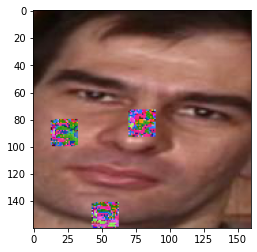

In [23]:
import matplotlib.pyplot as plt
plt.imshow(frame)

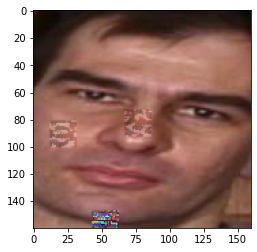

In [19]:
import matplotlib.pyplot as plt
plt.imshow(frame)

In [23]:
init_pred

tensor([[0]], device='cuda:0')

In [39]:
y

18

In [40]:
final_pred = torch.tensor([0])
final_pred.item()

0

In [33]:
output

tensor([[12.6261, -4.4244, -0.2591, -3.1263, -1.3244,  2.2342, -0.6793, -0.8329,
          0.0217, -1.5481, -1.0694,  4.3946, -1.7098, -1.2465,  1.6164, -2.1657,
         -2.5186, -0.9879, -1.6666,  1.9673,  1.0288,  2.0583,  2.9214, -0.9704,
         -0.3920, -1.4438, -3.6762,  1.5202, -2.2672,  0.5098,  2.9988,  0.9742,
         -0.5143, -1.4245,  1.3012, -0.6120,  0.3502,  0.5048,  0.6199, -1.3218,
         -2.9227, -0.2797,  2.1490, -3.6917, -1.6612, -1.7505,  1.1411,  0.2146,
         -0.0397,  1.8503]], device='cuda:0', grad_fn=<AddmmBackward>)

In [35]:
output.max()

tensor(12.6261, device='cuda:0', grad_fn=<MaxBackward1>)